# CNN 이미지 분류
- PyTorch
- CIFAR-10 데이터셋

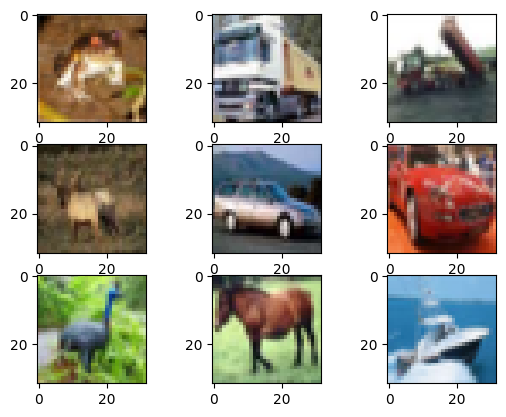

In [11]:
# 데이터 로드
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

train_data = CIFAR10(root="./", train=True, download=True, transform=ToTensor())
test_data = CIFAR10(root="./", train=False, download=True, transform=ToTensor())

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(train_data.data[i])
plt.show()

In [12]:
import torch
# 데이터셋 이미지의 평균과 표준편차 구하기
imgs = [item[0] for item in train_data]
imgs = torch.stack(imgs, dim=0).numpy()

# PyTorch 이미지 = 4차원 = (batch, channel, row, col)
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()

std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()

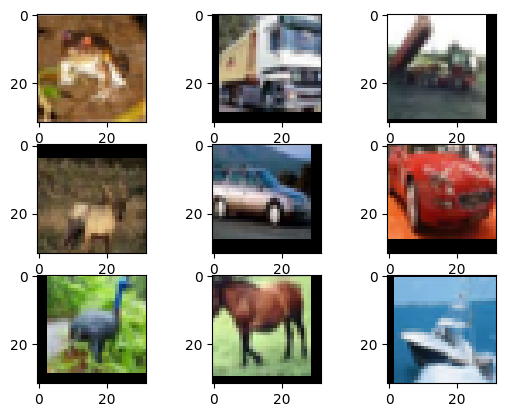

In [13]:
# 데이터 증강
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32, 32), padding=4),
    RandomHorizontalFlip(p=0.5)
])

train_data = CIFAR10(root="./", train=True, download=True, transform=transforms)
test_data = CIFAR10(root="./", train=False, download=True, transform=transforms)

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(transforms(train_data.data[i]))
plt.show()

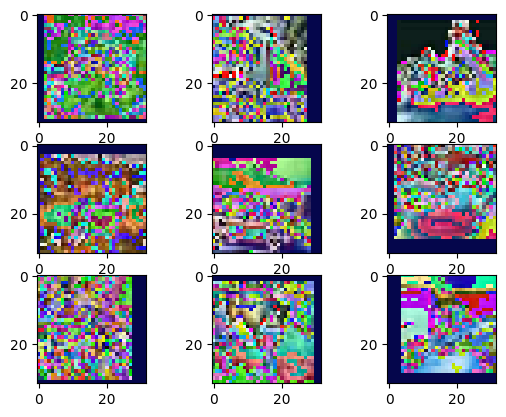

In [15]:
# 이미지 정규화
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32, 32), padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    T.ToPILImage()
])

train_data = CIFAR10(root="./", train=True, download=True, transform=transforms)
test_data = CIFAR10(root="./", train=False, download=True, transform=transforms)

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(transforms(train_data.data[i]))
plt.show()

In [18]:
import torch.nn as nn

class CBlock(nn.Module):
  def __init__(self, in_channels, out_channels, hidden_dim):
    super(CBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels=in_channels,
        out_channels=hidden_dim,
        kernel_size=3,
        padding=1
    )
    self.conv2 = nn.Conv2d(
        in_channels=hidden_dim,
        out_channels=out_channels,
        kernel_size=3,
        padding=1
    )
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    return x

In [19]:
class CNN(nn.Module):
  def __init__(self, num_classes):
    super(CNN, self).__init__()
    self.block1 = CBlock(in_channels=3, out_channels=32, hidden_dim=16)
    self.block2 = CBlock(in_channels=32, out_channels=128, hidden_dim=64)
    self.block3 = CBlock(in_channels=128, out_channels=256, hidden_dim=128)

    self.fc1 = nn.Linear(in_features=4096, out_features=2048)
    self.fc2 = nn.Linear(in_features=2048, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = torch.flatten(x, start_dim=1)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)

    return x

In [22]:
# DataLoader 준비
from torch.utils.data.dataloader import DataLoader

transforms = Compose([
    RandomCrop((32, 32), padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

train_data = CIFAR10(root="./", train=True, download=True, transform=transforms)
test_data = CIFAR10(root="./", train=False, download=True, transform=transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [25]:
from torch.optim.adam import Adam

# 학습
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN(num_classes=10)
model.to(device)

learning_rate = 1e-3
optim = Adam(model.parameters(), lr=learning_rate)

for epoch in range(100):
  for data, label in train_loader:
    optim.zero_grad()
    preds = model(data.to(device))

    loss = nn.CrossEntropyLoss()(preds, label.to(device))
    loss.backward()
    optim.step()

  if (epoch + 1) % 10 == 0:
    print(f"Epoch {epoch + 1} | loss: {loss.item():.4f}")

torch.save(model.state_dict(), "CIFAR10.pt")

Epoch 10 | loss: 0.8932
Epoch 20 | loss: 1.2060
Epoch 30 | loss: 0.3554
Epoch 40 | loss: 0.7977
Epoch 50 | loss: 0.2920
Epoch 60 | loss: 0.7621
Epoch 70 | loss: 0.2706
Epoch 80 | loss: 0.2769
Epoch 90 | loss: 0.6458
Epoch 100 | loss: 0.4006


In [26]:
# 평가
device = "cuda" if torch.cuda.is_available() else "cpu"

model.load_state_dict(torch.load("CIFAR10.pt", map_location=device))
cnt_corr = 0

with torch.no_grad():
  for data, label in test_loader:
    output = model(data.to(device))
    preds = output.data.max(1)[1]
    corr = preds.eq(label.to(device).data).sum().item()
    cnt_corr += corr

  print(f"Accuracy: {cnt_corr / len(test_data)}")

Accuracy: 0.8274
